In [1]:
using Revise
using DifferentialEquations
using Plots
using Thyrosim

┌ Info: Recompiling stale cache file /home/mauricio/.julia/compiled/v1.2/Thyrosim/Oo7R6.ji for Thyrosim [7ef34fca-2b35-11e9-1aeb-a527bedb189e]
└ @ Base loading.jl:1240


In [2]:
ic, p = initialize()
tspan = (0.0, 720.0)

prob = ODEProblem(original_thyrosim, ic, tspan, p)
sol = solve(prob)

retcode: Success
Interpolation: Automatic order switching interpolation
t: 2138-element Array{Float64,1}:
   0.0               
   0.191158773062677 
   0.3480570160954878
   0.6023855330343819
   0.9019286992888549
   1.2074915486018467
   1.4823506003082172
   1.7243191465028676
   1.9465873454094764
   2.162795649893725 
   2.3816014353107913
   2.6063705181033017
   2.836660026404979 
   ⋮                 
 716.5018974195684   
 716.8940925070216   
 717.2735782473748   
 717.6413205164702   
 717.9982921714501   
 718.3454562065733   
 718.6837565054185   
 719.0141142739297   
 719.337428802944    
 719.6545817200134   
 719.9664443028531   
 720.0               
u: 2138-element Array{Array{Float64,1},1}:
 [0.322114215761171, 0.201296960359917, 0.63896741190756, 0.00663104034826483, 0.0112595761822961, 0.0652960640300348, 1.7882958476437, 7.05727560072869, 7.05714474742141, 0.0, 0.0, 0.0, 0.0, 3.34289716182018, 3.69277248068433, 3.87942133769244, 3.90061903207543, 3.7787573428357

In [7]:
plot(sol)

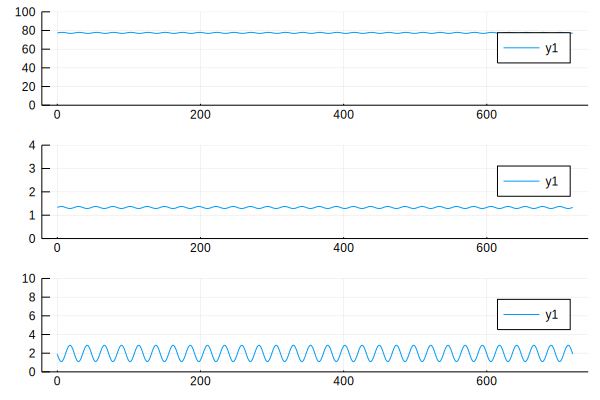

In [9]:
p1 = plot(sol.t, 777.0 * sol[1, :] / p[47], ylim=(0, 100))
p2 = plot(sol.t, 651.0 * sol[4, :] / p[47], ylim=(0, 4))
p3 = plot(sol.t, 5.6 * sol[7, :] / p[48], ylim=(0, 10))
plot(p1, p2, p3, layout=(3, 1))

## Implementing dosing

Let's first try to incorporate a single T4 dose into the model at 24 hours.

In [10]:
ic, p = initialize();
tspan = (0.0, 720.0);

function condition(u, t, integrator)
    return t - 24.0
end
    
function affect!(integrator)
    T4_dose = 1.6 * 70.0 / 777.0;
    T3_dose = 0.0;
    
    ## CHECK: Should probably be adding to pill compartments 10, 12 but do this same way as Simon's code so
    ## we can compare.
    integrator.u[11] += T4_dose
    integrator.u[13] += T3_dose
end

cbk = ContinuousCallback(condition, affect!);

prob = ODEProblem(original_thyrosim, ic, tspan, p, callback=cbk);
sol = solve(prob);

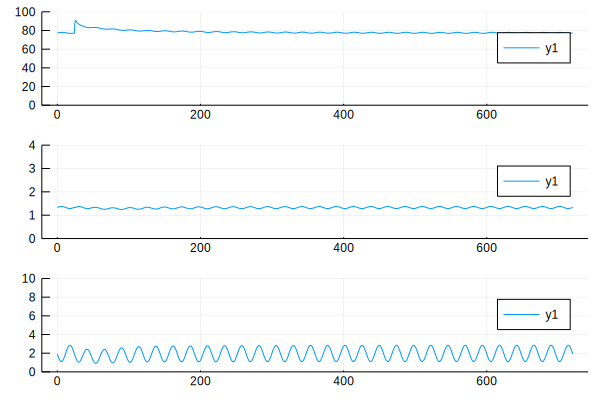

In [11]:
p1 = plot(sol.t, 777.0 * sol[1, :] / p[47], ylim=(0, 100))
p2 = plot(sol.t, 651.0 * sol[4, :] / p[47], ylim=(0, 4))
p3 = plot(sol.t, 5.6 * sol[7, :] / p[48], ylim=(0, 10))
plot(p1, p2, p3, layout=(3, 1))

This works! It's may not be straightforward to generalize this, but let's see if we can get it to do periodic dosing.

In [12]:
using DiffEqCallbacks

ArgumentError: ArgumentError: Package DiffEqCallbacks not found in current path:
- Run `import Pkg; Pkg.add("DiffEqCallbacks")` to install the DiffEqCallbacks package.


In [13]:
function output_plot(sol)
    p1 = plot(sol.t / 24.0, 777.0 * sol[1, :] / p[47], ylim=(0, 115), label="",
       ylabel="T4", title="Thyrosim simulation")
    p1 = hline!([45, 105], label= "")
    
    p2 = plot(sol.t / 24.0, 651.0 * sol[4, :] / p[47], ylim=(0, 4), label="", 
       ylabel="T3")
    p2 = hline!([0.6, 1.8], label= "")
    
    p3 = plot(sol.t / 24.0, 5.6 * sol[7, :] / p[48], ylim=(0, 10), label="",
       ylabel="TSH", xlabel="time [days]")
    p3 = hline!([0.45, 4.5], label= "")
    
    plot(p1, p2, p3, layout=(3, 1))
    
    ## Need to change to pick better y limits!
end
    

output_plot (generic function with 1 method)

In [14]:
ic, p = initialize([0.0, 0.0, 0.0, 0.0]);
tspan = (0.0, 720.0);

#function condition(u, t, integrator)
#    return t - 24.0
#end
    
function affect!(integrator)
    T4_dose = 1.6 * 70.0 / 777.0;
    T3_dose = 0.0;
    
    ## CHECK: Should probably be adding to pill compartments 10, 12 but do this same way as Simon's code so
    ## we can compare.
    integrator.u[11] += T4_dose
    integrator.u[13] += T3_dose
end

cbk = PeriodicCallback(affect!, 24.0);

prob = ODEProblem(original_thyrosim, ic, tspan, p, callback=cbk);
sol = solve(prob);

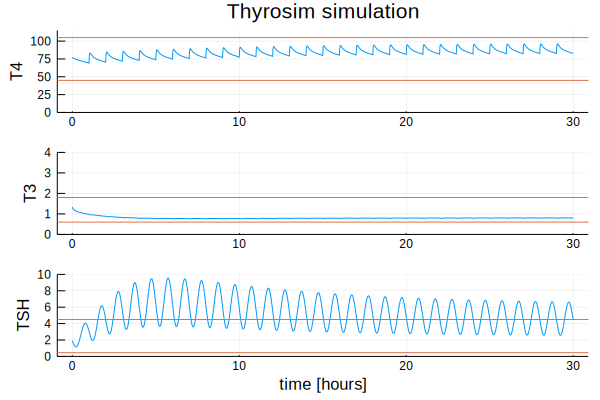

In [15]:
output_plot(sol)

This works! Now it only remains to try and get it to only start giving doses at specific places.

In [16]:
ic, p = initialize([0.0, 0.0, 0.0, 0.0]);
tspan = (0.0, 720.0);

#function condition(u, t, integrator)
#    return t - 24.0
#end
    
function affect!(t, u, integrator)
    T4_dose = 1.6 * 70.0 / 777.0;
    T3_dose = 0.0;
    
    ## CHECK: Should probably be adding to pill compartments 10, 12 but do this same way as Simon's code so
    ## we can compare.
    integrator.u[11] += T4_dose
    integrator.u[13] += T3_dose
end
cbk = FunctionCallingCallback(affect!;
                 funcat=[24.0, 48.0, 72.0, 240.0],
                 func_start = false)

prob = ODEProblem(original_thyrosim, ic, tspan, p, callback=cbk);
sol = solve(prob);

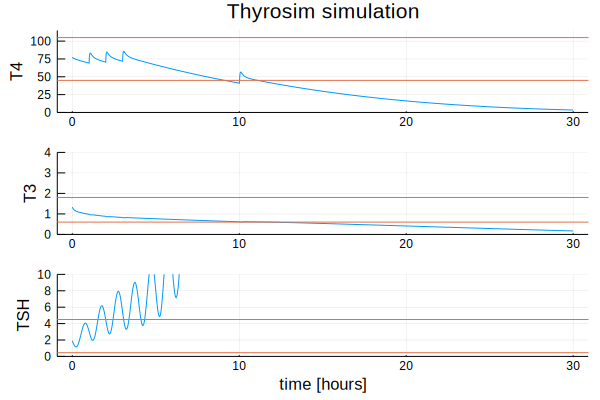

In [17]:
output_plot(sol)

In [18]:
sol(720.0)

19-element Array{Float64,1}:
   0.014228347979445255  
   0.007074752963031701  
   0.02246079700140505   
   0.0008473903604842873 
   0.0012399729318705358 
   0.009419234258462786  
 125.89425093299938      
   1.6304407223174167    
   2.848773772958312     
   0.0                   
   2.478569033353278e-190
   0.0                   
   0.0                   
 202.5908005159294       
 203.0968916566979       
 202.81656753552016      
 201.722073148524        
 199.9143696208067       
 197.58908089278543      

In [20]:
t, data400, data450, data600 = blakesley_data()

([0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0, 6.0, 8.0  …  30.0, 32.0, 34.0, 36.0, 42.0, 48.0, 60.0, 72.0, 96.0, 120.0], [77.24000000000001 1.268 1.74; 76.65 1.24 1.689; … ; 84.02000000000001 1.147 0.987; 83.99000000000001 1.229 1.391], [78.14 1.265 1.653; 76.97 1.256 1.579; … ; 87.91 1.174 0.778; 84.42 1.207 1.133], [73.52000000000001 1.264 1.896; 73.24 1.256 1.776; … ; 88.84 1.175 0.582; 86.18 1.216 0.861])

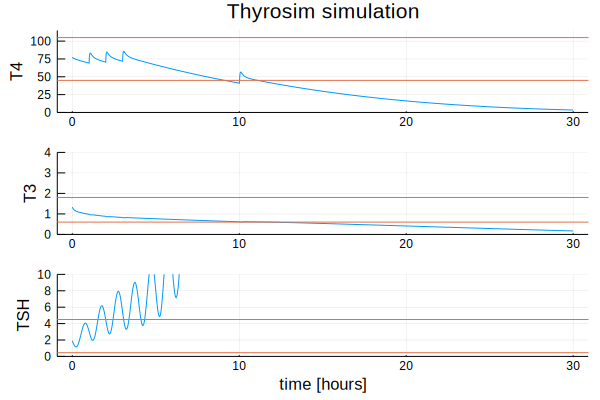

In [21]:
p = output_plot(sol)

In [9]:
ic, p = initialize();
tspan = (0.0, 120.0);

function condition(u, t, integrator)
    return t - 24.0;
end
    
function affect!(integrator)
    T4_dose = 400.0 / 777.0;
    T3_dose = 0.0;
    
    ## CHECK: Should probably be adding to pill compartments 10, 12 but do this same way as Simon's code so
    ## we can compare.
    integrator.u[11] += T4_dose;
    integrator.u[13] += T3_dose;
end

cbk = ContinuousCallback(condition, affect!);

prob = ODEProblem(original_thyrosim, ic, tspan, p, callback=cbk);
sol = solve(prob);


In [28]:
function plot_blakesley(sol, which="400")
    markersize = 2
    t_data, data400, data450, data600 = blakesley_data()
    if which == "400"
        data = data400
    elseif which == "450"
        data = data450
    else
        data = data600
    end
    
    t_data = t_data / 24.0
            
    ## Need to change to pick better y limits!
    p1 = plot(sol.t / 24.0, 777.0 * sol[1, :] / p[47], ylim=(0, 140), label="",
       ylabel="T4", title="Thyrosim simulation")
    p1 = hline!([45, 105], label= "")
    p1 = scatter!(t_data, data[:, 1], label="", markersize=markersize)
    
    p2 = plot(sol.t / 24.0, 651.0 * sol[4, :] / p[47], ylim=(0, 4), label="", 
       ylabel="T3")
    p2 = hline!([0.6, 1.8], label= "")
    p2 = scatter!(t_data, data[:, 2], label="", markersize=markersize)
    
    p3 = plot(sol.t / 24.0, 5.6 * sol[7, :] / p[48], ylim=(0, 10), label="",
       ylabel="TSH", xlabel="time [days]")
    p3 = hline!([0.45, 4.5], label= "")
    p3 = scatter!(t_data, data[:, 3], label="", markersize=markersize)
    
    plot(p1, p2, p3, layout=(3, 1))
    #return p
end

plot_blakesley (generic function with 2 methods)

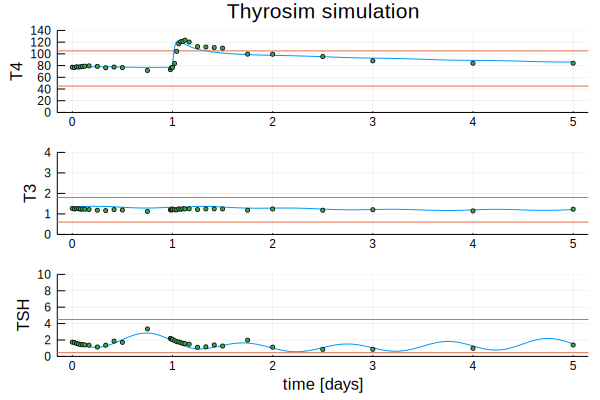

In [29]:
plot_blakesley(sol, "400")